In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
db = np.load('pahdb.npy', allow_pickle=True)
db[961]['spectrum'] = np.delete(db[961]['spectrum'], -1, axis=0)  # 异常值处理

bans = []
elements = ['+', '-', 'N', 'O', 'Mg', 'Si', 'Fe']
for i in range(db.shape[0]):
    for e in elements:
        if e in db[i]['formula']:
            bans.append(i)
            break

db = np.delete(db, bans)

In [3]:
seed = 0
db_train, db_test = train_test_split(db, test_size=0.2, random_state=seed)
db_train.shape

(2347,)

In [4]:
max_fp_len = max(i['fingerprint'].shape[0] for i in db_train)
fp_set = np.delete(np.unique([np.pad(i['fingerprint'], [0, max_fp_len - i['fingerprint'].shape[0]]) for i in db_train]), 0)

fp_train = pd.DataFrame(np.zeros((db_train.shape[0], fp_set.shape[0]), dtype=int), columns=fp_set)
fp_test = pd.DataFrame(np.zeros((db_test.shape[0], fp_set.shape[0]), dtype=int), columns=fp_set)

for i in range(db_train.shape[0]):
    for fp in db_train[i]['fingerprint']:
        fp_train[fp][i] = 1
for i in range(db_test.shape[0]):
    for fp in db_test[i]['fingerprint']:
        if fp in fp_set:
            fp_test[fp][i] = 1

In [5]:
bins = 256

max_fre_len = max(i['spectrum'].shape[0] for i in db_train)
fre = pd.DataFrame(np.array(
    [np.pad(i['spectrum'][:, 0], [0, max_fre_len - i['spectrum'].shape[0]], constant_values=np.nan) for i in db_train]).ravel())
fre['cut'] = pd.cut(fre[0], bins, precision=5)
cut = fre['cut'].value_counts(sort=False)
# cut = cut.drop(index=cut.index[cut == 0])

spec_train = pd.DataFrame(np.zeros((db_train.shape[0], bins)), columns=cut.index)
for i in range(db_train.shape[0]):
    isum = db_train[i]['spectrum'][:, 1].sum()
    for j in range(db_train[i]['spectrum'].shape[0]):
        spec_train[fre['cut'][i * max_fre_len + j]][i] += db_train[i]['spectrum'][j, 1] / isum

rights = [i.right for i in cut.index]
spec_test = pd.DataFrame(np.zeros((db_test.shape[0], bins)), columns=cut.index)
for i in range(db_test.shape[0]):
    isum = db_test[i]['spectrum'][:, 1].sum()
    col = 0
    for j in range(db_test[i]['spectrum'].shape[0]):
        while db_test[i]['spectrum'][j, 0] > rights[col] and col < bins - 1:
            col += 1
        spec_test.iloc[i, col] += db_test[i]['spectrum'][j, 1] / isum

In [6]:
def emd_loss(y_true, y_pred):
#     y_true = y_true / tf.reduce_sum(y_true, axis=-1)[:, None]
#     y_pred = y_pred / tf.reduce_sum(y_pred, axis=-1)[:, None]
    loss = tf.math.abs(tf.math.cumsum(y_true - y_pred, axis=-1))
    return tf.reduce_sum(loss, axis=-1)

In [8]:
%%time

rate = 0.
batch_size = 32

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(1024, activation='relu'),
#     tf.keras.layers.Dropout(rate),
    tf.keras.layers.Dense(bins),
    tf.keras.layers.Lambda(lambda x: tf.math.abs(x)),
    tf.keras.layers.Lambda(lambda x: x / tf.reduce_sum(x, axis=-1)[:, None])
])

model.compile(loss=emd_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=[])
model.fit(fp_train, spec_train, batch_size=batch_size, epochs=1000, validation_data=(fp_test, spec_test), verbose=2,
          callbacks=[tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, verbose=1, min_lr=1e-6)])

# 3.5031

Epoch 1/1000
74/74 - 1s - loss: 10.4351 - val_loss: 6.5414
Epoch 2/1000
74/74 - 0s - loss: 5.9593 - val_loss: 5.9252
Epoch 3/1000
74/74 - 0s - loss: 5.3191 - val_loss: 5.2607
Epoch 4/1000
74/74 - 0s - loss: 4.7469 - val_loss: 4.9645
Epoch 5/1000
74/74 - 0s - loss: 4.4973 - val_loss: 5.3343
Epoch 6/1000
74/74 - 0s - loss: 4.3180 - val_loss: 4.7268
Epoch 7/1000
74/74 - 0s - loss: 3.9592 - val_loss: 4.4792
Epoch 8/1000
74/74 - 0s - loss: 3.8508 - val_loss: 4.5837
Epoch 9/1000
74/74 - 0s - loss: 3.6182 - val_loss: 4.3572
Epoch 10/1000
74/74 - 0s - loss: 3.5618 - val_loss: 4.5379
Epoch 11/1000
74/74 - 0s - loss: 3.4974 - val_loss: 4.4721
Epoch 12/1000
74/74 - 0s - loss: 3.4601 - val_loss: 4.5703
Epoch 13/1000
74/74 - 0s - loss: 3.4353 - val_loss: 4.2685
Epoch 14/1000
74/74 - 0s - loss: 3.1897 - val_loss: 4.2643
Epoch 15/1000
74/74 - 0s - loss: 3.1518 - val_loss: 4.2760
Epoch 16/1000
74/74 - 0s - loss: 3.0806 - val_loss: 4.2454
Epoch 17/1000
74/74 - 0s - loss: 3.0531 - val_loss: 4.1783
Epoch

Epoch 138/1000
74/74 - 0s - loss: 1.4769 - val_loss: 3.4761
Epoch 139/1000
74/74 - 0s - loss: 1.4570 - val_loss: 3.4558
Epoch 140/1000
74/74 - 0s - loss: 1.4622 - val_loss: 3.4595
Epoch 141/1000
74/74 - 0s - loss: 1.4642 - val_loss: 3.4708
Epoch 142/1000
74/74 - 0s - loss: 1.4646 - val_loss: 3.4404
Epoch 143/1000
74/74 - 0s - loss: 1.4442 - val_loss: 3.4814
Epoch 144/1000
74/74 - 0s - loss: 1.4801 - val_loss: 3.4593
Epoch 145/1000
74/74 - 0s - loss: 1.4615 - val_loss: 3.4582
Epoch 146/1000
74/74 - 0s - loss: 1.4549 - val_loss: 3.4328
Epoch 147/1000
74/74 - 0s - loss: 1.4584 - val_loss: 3.4680
Epoch 148/1000
74/74 - 0s - loss: 1.4379 - val_loss: 3.4849
Epoch 149/1000
74/74 - 0s - loss: 1.4544 - val_loss: 3.4659
Epoch 150/1000
74/74 - 0s - loss: 1.4466 - val_loss: 3.4910
Epoch 151/1000
74/74 - 0s - loss: 1.4628 - val_loss: 3.4525
Epoch 152/1000
74/74 - 0s - loss: 1.4318 - val_loss: 3.4761
Epoch 153/1000
74/74 - 0s - loss: 1.4505 - val_loss: 3.4925
Epoch 154/1000
74/74 - 0s - loss: 1.4474

Epoch 272/1000
74/74 - 0s - loss: 1.1860 - val_loss: 3.3483
Epoch 273/1000
74/74 - 0s - loss: 1.1841 - val_loss: 3.3450
Epoch 274/1000
74/74 - 0s - loss: 1.1862 - val_loss: 3.3512
Epoch 275/1000
74/74 - 0s - loss: 1.1857 - val_loss: 3.3404
Epoch 276/1000
74/74 - 0s - loss: 1.1868 - val_loss: 3.3402
Epoch 277/1000
74/74 - 0s - loss: 1.1900 - val_loss: 3.3367
Epoch 278/1000
74/74 - 0s - loss: 1.1889 - val_loss: 3.3392
Epoch 279/1000
74/74 - 0s - loss: 1.1850 - val_loss: 3.3278
Epoch 280/1000
74/74 - 0s - loss: 1.1856 - val_loss: 3.3457
Epoch 281/1000
74/74 - 0s - loss: 1.1849 - val_loss: 3.3337
Epoch 282/1000
74/74 - 0s - loss: 1.1865 - val_loss: 3.3360
Epoch 283/1000
74/74 - 0s - loss: 1.1885 - val_loss: 3.3429

Epoch 00283: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 284/1000
74/74 - 0s - loss: 1.1711 - val_loss: 3.3369
Epoch 285/1000
74/74 - 0s - loss: 1.1634 - val_loss: 3.3259
Epoch 286/1000
74/74 - 0s - loss: 1.1612 - val_loss: 3.3324
Epoch 287/1000
74/74

74/74 - 0s - loss: 1.1321 - val_loss: 3.3368
Epoch 408/1000
74/74 - 0s - loss: 1.1294 - val_loss: 3.3326
Epoch 409/1000
74/74 - 0s - loss: 1.1287 - val_loss: 3.3372
Epoch 410/1000
74/74 - 0s - loss: 1.1319 - val_loss: 3.3297
Epoch 411/1000
74/74 - 0s - loss: 1.1289 - val_loss: 3.3339
Epoch 412/1000
74/74 - 0s - loss: 1.1290 - val_loss: 3.3359
Epoch 413/1000
74/74 - 0s - loss: 1.1297 - val_loss: 3.3344
Epoch 414/1000
74/74 - 0s - loss: 1.1298 - val_loss: 3.3331
Epoch 415/1000
74/74 - 0s - loss: 1.1294 - val_loss: 3.3374
Epoch 416/1000
74/74 - 0s - loss: 1.1257 - val_loss: 3.3366
Epoch 417/1000
74/74 - 0s - loss: 1.1303 - val_loss: 3.3374
Epoch 418/1000
74/74 - 0s - loss: 1.1337 - val_loss: 3.3379
Epoch 419/1000
74/74 - 0s - loss: 1.1307 - val_loss: 3.3332
Epoch 420/1000
74/74 - 0s - loss: 1.1298 - val_loss: 3.3372
Epoch 421/1000
74/74 - 0s - loss: 1.1287 - val_loss: 3.3346
Epoch 422/1000
74/74 - 0s - loss: 1.1265 - val_loss: 3.3373
Epoch 423/1000
74/74 - 0s - loss: 1.1296 - val_loss: 3.

74/74 - 0s - loss: 1.0973 - val_loss: 3.3351
Epoch 542/1000
74/74 - 0s - loss: 1.0969 - val_loss: 3.3358
Epoch 543/1000
74/74 - 0s - loss: 1.0968 - val_loss: 3.3347
Epoch 544/1000
74/74 - 0s - loss: 1.0968 - val_loss: 3.3345
Epoch 545/1000
74/74 - 0s - loss: 1.0966 - val_loss: 3.3349
Epoch 546/1000
74/74 - 0s - loss: 1.0961 - val_loss: 3.3349
Epoch 547/1000
74/74 - 0s - loss: 1.0962 - val_loss: 3.3345
Epoch 548/1000
74/74 - 0s - loss: 1.0963 - val_loss: 3.3349
Epoch 549/1000
74/74 - 0s - loss: 1.0965 - val_loss: 3.3373
Epoch 550/1000
74/74 - 0s - loss: 1.0963 - val_loss: 3.3355
Epoch 551/1000
74/74 - 0s - loss: 1.0964 - val_loss: 3.3359
Epoch 552/1000
74/74 - 0s - loss: 1.0961 - val_loss: 3.3361
Epoch 553/1000
74/74 - 0s - loss: 1.0959 - val_loss: 3.3342
Epoch 554/1000
74/74 - 0s - loss: 1.0963 - val_loss: 3.3348
Epoch 555/1000
74/74 - 0s - loss: 1.0960 - val_loss: 3.3377
Epoch 556/1000
74/74 - 0s - loss: 1.0956 - val_loss: 3.3348
Epoch 557/1000
74/74 - 0s - loss: 1.0954 - val_loss: 3.

Epoch 678/1000
74/74 - 0s - loss: 1.0876 - val_loss: 3.3368
Epoch 679/1000
74/74 - 0s - loss: 1.0879 - val_loss: 3.3395
Epoch 680/1000
74/74 - 0s - loss: 1.0871 - val_loss: 3.3362
Epoch 681/1000
74/74 - 0s - loss: 1.0867 - val_loss: 3.3395
Epoch 682/1000
74/74 - 0s - loss: 1.0869 - val_loss: 3.3365
Epoch 683/1000
74/74 - 0s - loss: 1.0859 - val_loss: 3.3402
Epoch 684/1000
74/74 - 0s - loss: 1.0864 - val_loss: 3.3384
Epoch 685/1000
74/74 - 0s - loss: 1.0862 - val_loss: 3.3398
Epoch 686/1000
74/74 - 0s - loss: 1.0862 - val_loss: 3.3392
Epoch 687/1000
74/74 - 0s - loss: 1.0863 - val_loss: 3.3382
Epoch 688/1000
74/74 - 0s - loss: 1.0863 - val_loss: 3.3388
Epoch 689/1000
74/74 - 0s - loss: 1.0858 - val_loss: 3.3398
Epoch 690/1000
74/74 - 0s - loss: 1.0866 - val_loss: 3.3390
Epoch 691/1000
74/74 - 0s - loss: 1.0862 - val_loss: 3.3372
Epoch 692/1000
74/74 - 0s - loss: 1.0857 - val_loss: 3.3392
Epoch 693/1000
74/74 - 0s - loss: 1.0860 - val_loss: 3.3376
Epoch 694/1000
74/74 - 0s - loss: 1.0853

74/74 - 0s - loss: 1.0764 - val_loss: 3.3403
Epoch 814/1000
74/74 - 0s - loss: 1.0761 - val_loss: 3.3398
Epoch 815/1000
74/74 - 0s - loss: 1.0762 - val_loss: 3.3406
Epoch 816/1000
74/74 - 0s - loss: 1.0762 - val_loss: 3.3395
Epoch 817/1000
74/74 - 0s - loss: 1.0763 - val_loss: 3.3398
Epoch 818/1000
74/74 - 0s - loss: 1.0760 - val_loss: 3.3404
Epoch 819/1000
74/74 - 0s - loss: 1.0761 - val_loss: 3.3396
Epoch 820/1000
74/74 - 0s - loss: 1.0764 - val_loss: 3.3403
Epoch 821/1000
74/74 - 0s - loss: 1.0762 - val_loss: 3.3413
Epoch 822/1000
74/74 - 0s - loss: 1.0762 - val_loss: 3.3409
Epoch 823/1000
74/74 - 0s - loss: 1.0759 - val_loss: 3.3402
Epoch 824/1000
74/74 - 0s - loss: 1.0758 - val_loss: 3.3413
Epoch 825/1000
74/74 - 0s - loss: 1.0760 - val_loss: 3.3397
Epoch 826/1000
74/74 - 0s - loss: 1.0757 - val_loss: 3.3406
Epoch 827/1000
74/74 - 0s - loss: 1.0757 - val_loss: 3.3395
Epoch 828/1000
74/74 - 0s - loss: 1.0757 - val_loss: 3.3406
Epoch 829/1000
74/74 - 0s - loss: 1.0758 - val_loss: 3.

Epoch 949/1000
74/74 - 0s - loss: 1.0712 - val_loss: 3.3396
Epoch 950/1000
74/74 - 0s - loss: 1.0711 - val_loss: 3.3402
Epoch 951/1000
74/74 - 0s - loss: 1.0711 - val_loss: 3.3403
Epoch 952/1000
74/74 - 0s - loss: 1.0712 - val_loss: 3.3408
Epoch 953/1000
74/74 - 0s - loss: 1.0710 - val_loss: 3.3406
Epoch 954/1000
74/74 - 0s - loss: 1.0710 - val_loss: 3.3404
Epoch 955/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3400
Epoch 956/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3410
Epoch 957/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3403
Epoch 958/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3405
Epoch 959/1000
74/74 - 0s - loss: 1.0710 - val_loss: 3.3406
Epoch 960/1000
74/74 - 0s - loss: 1.0708 - val_loss: 3.3401
Epoch 961/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3401
Epoch 962/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3403
Epoch 963/1000
74/74 - 0s - loss: 1.0709 - val_loss: 3.3407
Epoch 964/1000
74/74 - 0s - loss: 1.0708 - val_loss: 3.3407
Epoch 965/1000
74/74 - 0s - loss: 1.0708

<BarContainer object of 256 artists>

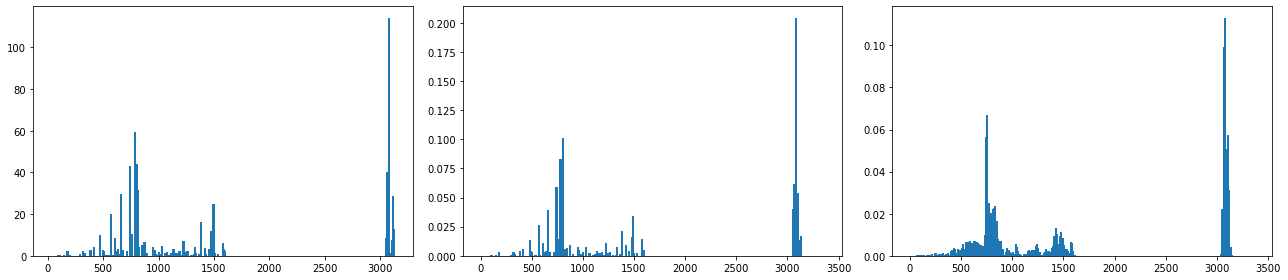

In [14]:
i = 0

fig, axes = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
axes[0].bar(db_test[i]['spectrum'][:, 0], db_test[i]['spectrum'][:, 1], width=20)
axes[1].bar([i.mid for i in cut.index], spec_test.loc[i], width=20)
axes[2].bar([i.mid for i in cut.index], model.predict(fp_test.loc[[i]])[0], width=20)